<a href="https://colab.research.google.com/github/footpr1nt5/Hackamotive/blob/main/agent_motion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries 
We import libraries to understand, visualize, train and predict. 

In [ ]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

 
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR
from prettytable import PrettyTable
from pathlib import Path

import os

### initialization

In [ ]:
from typing import Optional, Tuple

import cv2
import numpy as np

from l5kit.geometry import transform_point, transform_points

PREDICTED_POINTS_COLOR = (0, 255, 255)
TARGET_POINTS_COLOR = (255, 0, 255)
REFERENCE_TRAJ_COLOR = (255, 255, 0)
#  Arrows represent position + orientation.
ARROW_LENGTH_IN_PIXELS = 2
ARROW_THICKNESS_IN_PIXELS = 1
ARROW_TIP_LENGTH_IN_PIXELS = 1.8

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [ ]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/tarun/Lyft/prediction-dataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [ ]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [ ]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

## Load the Train Data

Our data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [ ]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 34.20261001586914 loss(avg): 70.36944007873535: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]  


### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

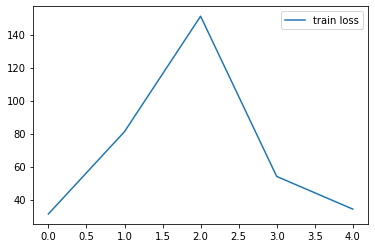

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

copying: 100%|██████████| 100/100 [00:00<00:00, 100.91it/s]
/home/tarun/test/lib/python3.6/site-packages/l5kit/evaluation/extract_ground_truth.py:59: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:03<00:00, 143.28it/s]


The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/home/tarun/test/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []
    
    for agent_coords, world_from_agent, centroid in zip(agents_coords, world_from_agents, centroids):
        coords_offset.append(transform_points(agent_coords, world_from_agent) - centroid[:2])
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 5908.2413630664505
time_displace [ 0.82985985  0.96510302  1.38613456  1.44544616  2.15881704  2.45244265
  3.02550428  3.33973369  3.61205728  3.93074787  4.27902857  4.65122606
  4.91845722  5.27450802  5.52579155  5.86636766  6.08528445  6.38599791
  6.71767475  7.08050635  7.4237554   7.73602024  7.94999771  8.37050562
  8.69277775  8.9933001   9.24648773  9.43475592  9.77391584  9.83991963
 10.13875467 10.44578588 10.8383825  10.82655853 11.25967621 11.46103873
 11.83001978 11.92234518 12.256246   12.33815408 12.68255762 12.95742386
 13.19318057 13.34878429 13.34121719 13.41269906 13.3965849  13.51781983
 13.59244125 14.04137899]


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


In [ ]:
def draw_arrowed_line(on_image: np.ndarray, position: np.ndarray, yaw: float, rgb_color: Tuple[int, int, int]) -> None:
    """
    Draw a single arrowed line in an RGB image
    Args:
        on_image (np.ndarray): the RGB image to draw onto
        position (np.ndarray): the starting position of the arrow
        yaw (float): the arrow orientation
        rgb_color (Tuple[int, int, int]): the arrow color
    Returns: None
    """
    start_pixel = np.array(position[:2])

    rot = cv2.getRotationMatrix2D((0, 0), np.degrees(-yaw), 1.0)  # minus here because of cv2 rotations convention
    end_pixel = start_pixel + transform_point(np.asarray([ARROW_LENGTH_IN_PIXELS, 0]), rot)

    cv2.arrowedLine(
        on_image,
        tuple(start_pixel.astype(np.int32)),
        tuple(end_pixel.astype(np.int32)),
        rgb_color,
        thickness=ARROW_THICKNESS_IN_PIXELS,
        tipLength=ARROW_TIP_LENGTH_IN_PIXELS,
    )
    print(start_pixel)
    
def draw_trajectory(
    on_image: np.ndarray,
    positions: np.ndarray,
    rgb_color: Tuple[int, int, int],
    radius: int = 1,
    yaws: Optional[np.ndarray] = None,
) -> None:
    """
    Draw a trajectory on oriented arrow onto an RGB image
    Args:
        on_image (np.ndarray): the RGB image to draw onto
        positions (np.ndarray): pixel coordinates in the image space (not displacements) (Nx2)
        rgb_color (Tuple[int, int, int]): the trajectory RGB color
        radius (int): radius of the circle
        yaws (Optional[np.ndarray]): yaws in radians (N) or None to disable yaw visualisation
    Returns: None
    """
    if yaws is not None:
        assert len(yaws) == len(positions)
        for pos, yaw in zip(positions, yaws):
            pred_waypoint = pos[:2]
            pred_yaw = float(yaw[0])
            draw_arrowed_line(on_image, pred_waypoint, pred_yaw, rgb_color)
    else:
        for pos in positions:
            pred_waypoint = pos[:2]
            cv2.circle(on_image, tuple(pred_waypoint.astype(np.int)), radius, rgb_color, -1)
def draw_reference_trajectory(on_image: np.ndarray, world_to_pixel: np.ndarray, positions: np.ndarray) -> None:
    """
    Draw a trajectory (as points) onto the image
    Args:
        on_image (np.ndarray): the RGB image to draw onto
        world_to_pixel (np.ndarray): 3x3 matrix from meters to ego pixel space
        positions (np.ndarray): positions as 2D absolute meters coordinates
    Returns: None
    """
    positions_in_pixel_space = transform_points(np.array(positions), world_to_pixel)
    #  we clip the positions to be within the image
    mask = np.all(positions_in_pixel_space > (0.0, 0.0), 1) * np.all(positions_in_pixel_space < on_image.shape[:2], 1)
    positions_in_pixel_space = positions_in_pixel_space[mask]
    for pos in positions_in_pixel_space:
        cv2.circle(on_image, tuple(np.floor(pos).astype(np.int32)), 1, REFERENCE_TRAJ_COLOR, -1)

### Visualizing predicted path of agents
We are predicting the location of agents 100 frames forward from the current frame.
The following code returns the predicted path of the agent in 85 scenes from dataset.

1


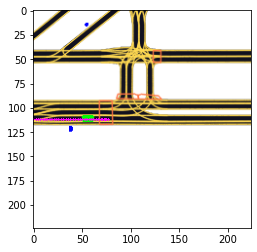

2


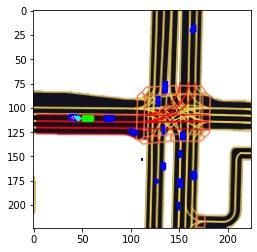

3


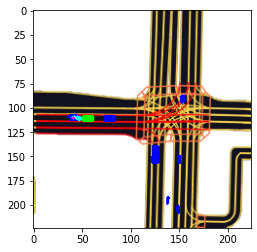

4


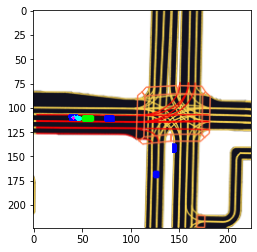

5


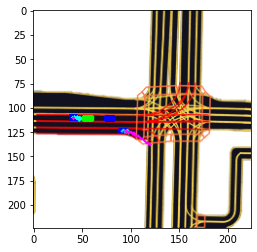

6


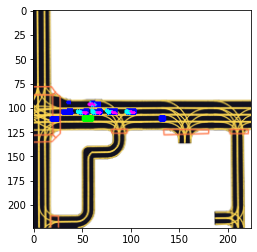

7


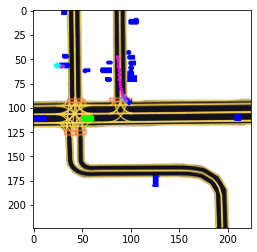

8


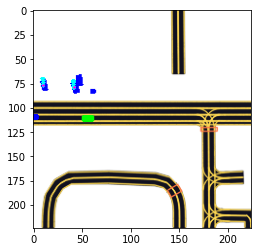

9


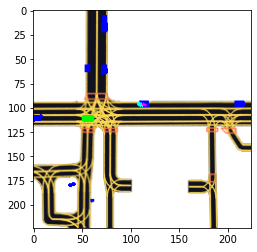

10


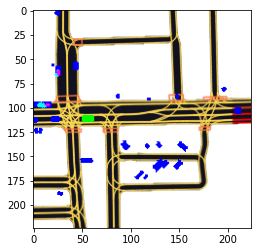

11


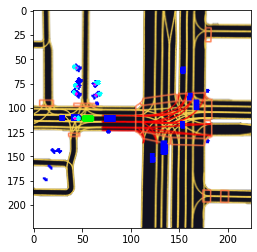

12


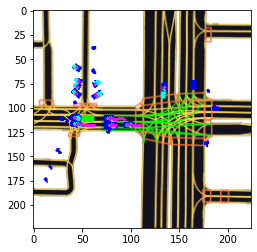

13


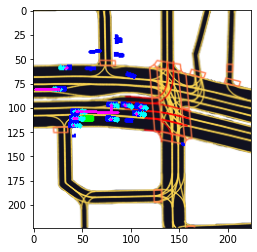

14


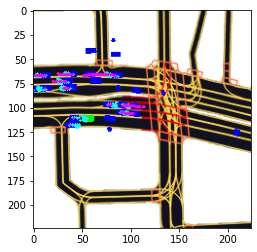

15


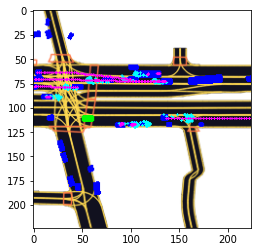

16


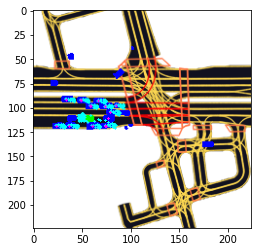

17


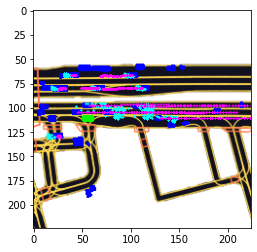

18


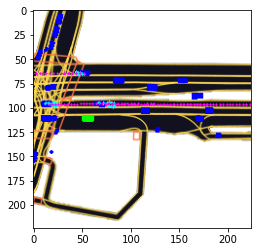

19


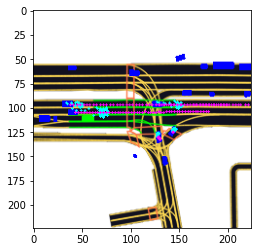

20


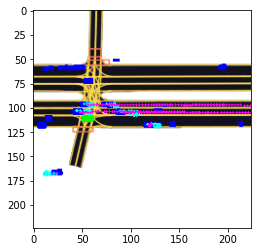

21


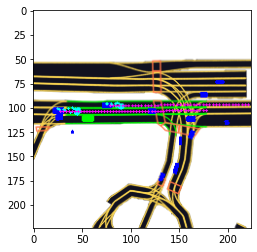

22


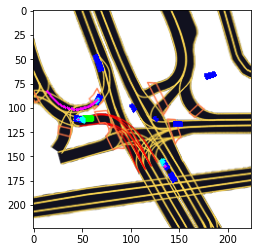

23


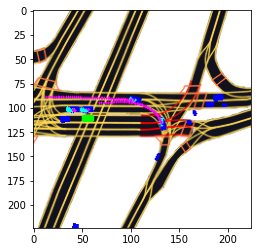

24


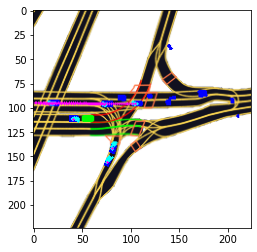

25


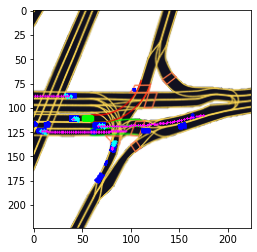

26


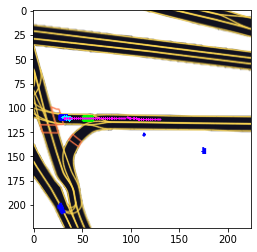

27


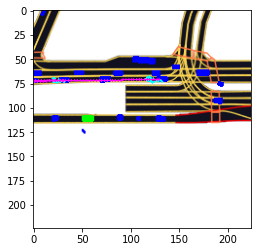

28


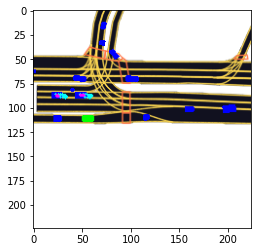

29


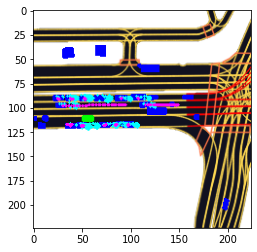

30


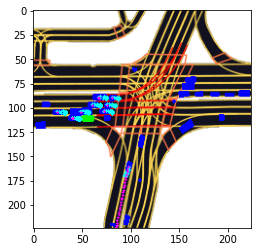

31


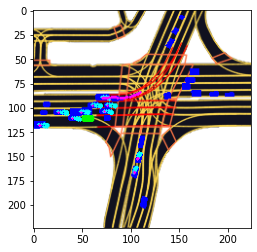

32


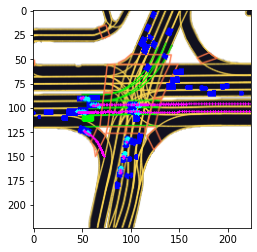

33


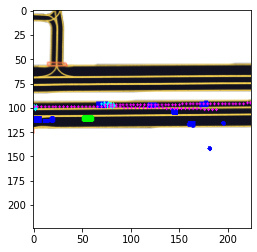

34


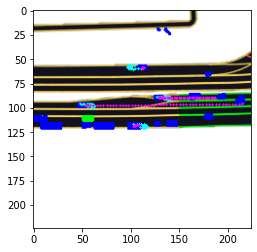

35


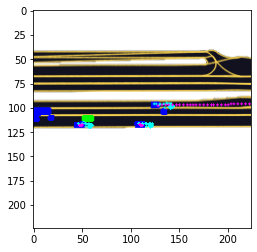

36


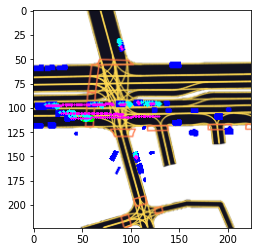

37


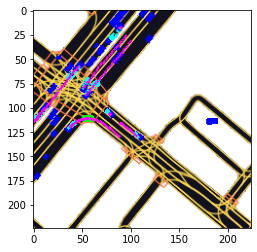

38


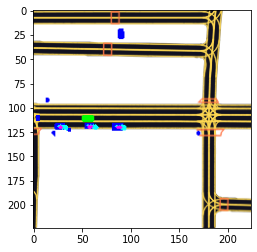

39


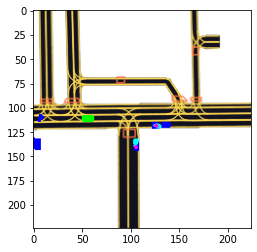

40


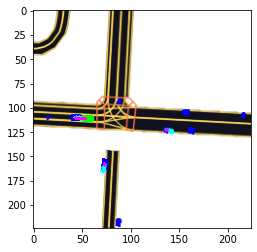

41


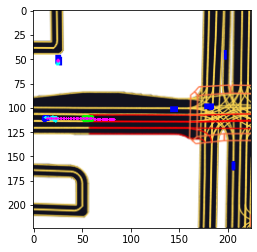

42


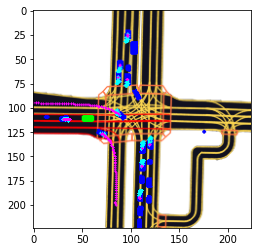

43


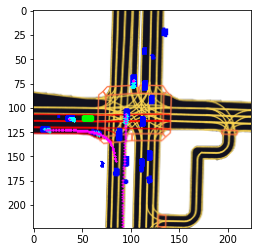

44


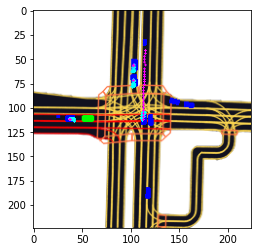

45


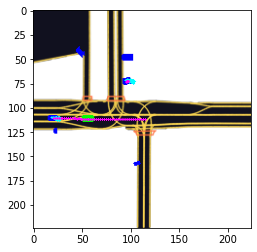

46


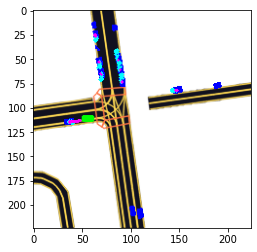

47


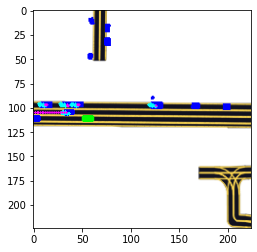

48


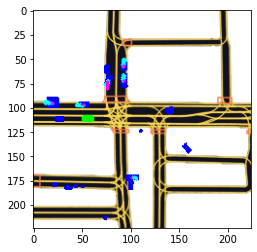

49


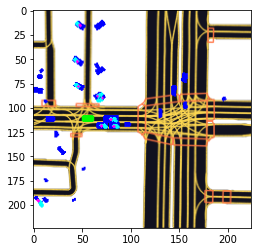

50


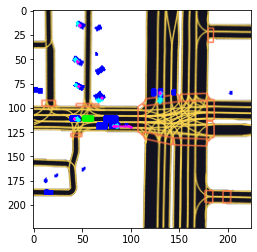

51


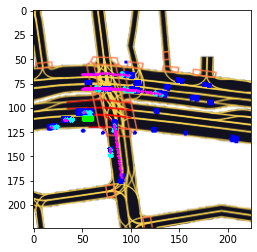

52


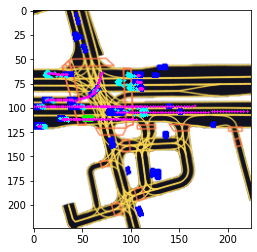

53


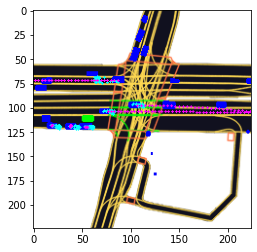

54


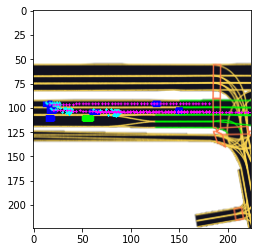

55


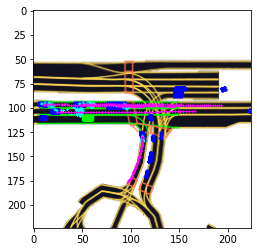

56


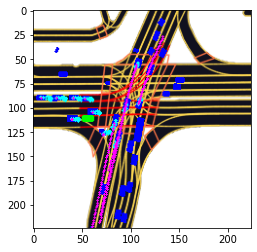

57


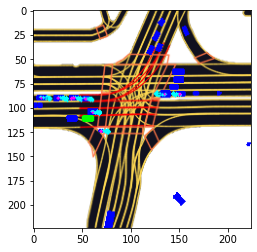

58


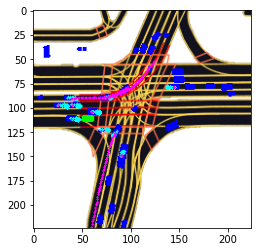

59


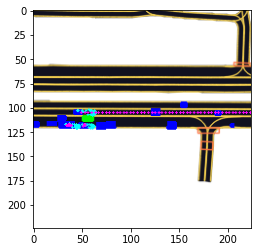

60


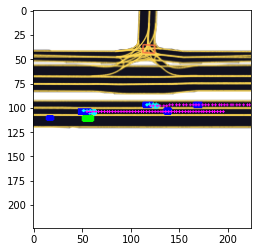

61


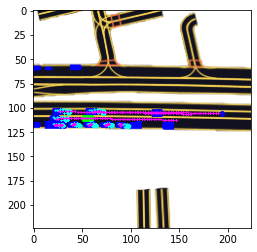

62


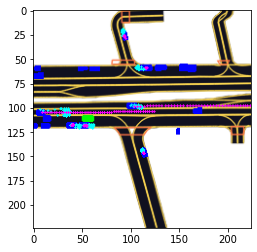

63


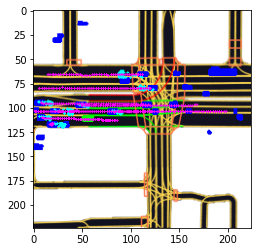

64


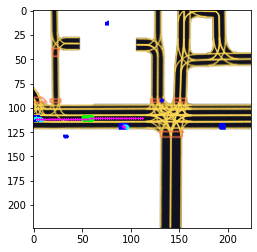

65


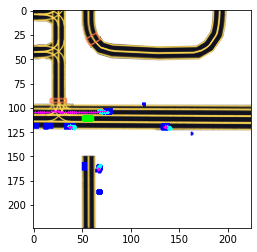

66


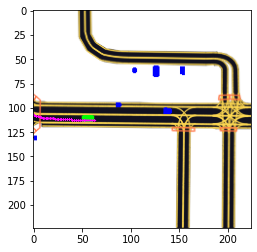

67


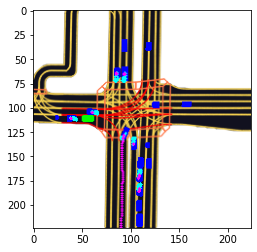

68


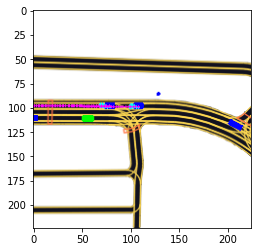

69


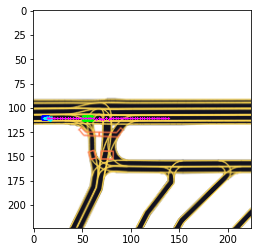

70


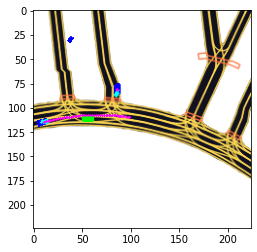

71


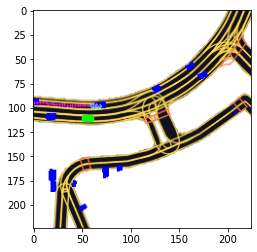

72


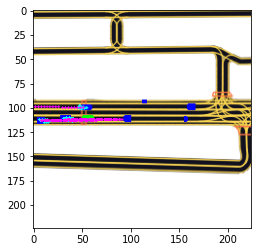

73


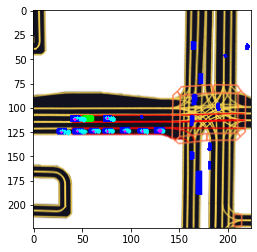

74


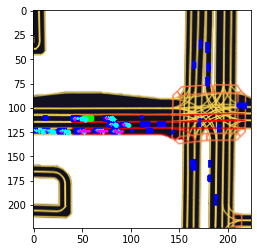

75


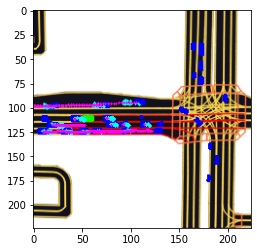

76


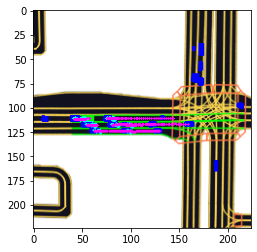

77


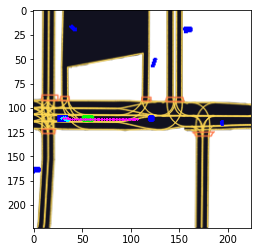

78


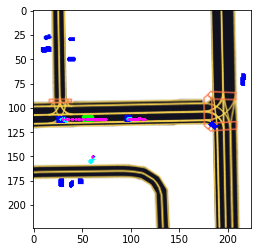

79


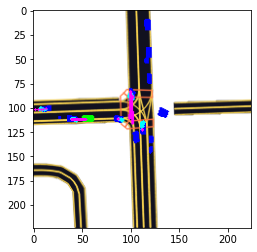

80


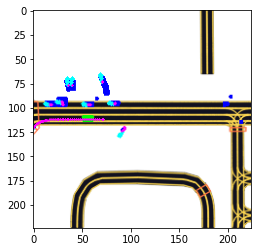

81


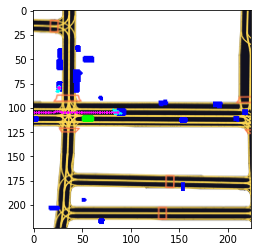

82


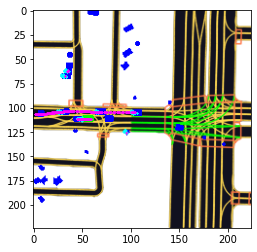

83


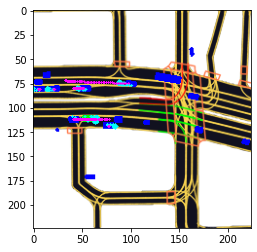

84


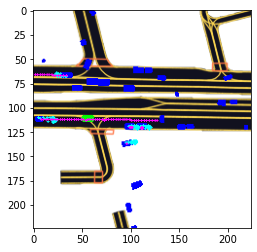

85


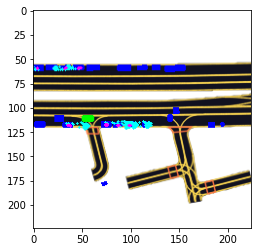

In [ ]:
model.eval()
torch.set_grad_enabled(False)
count = 0
# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    # print(predicted_positions)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    count +=1
    print(count)
    plt.imshow(im_ego[::-1])
    plt.show()

### Loading Ego vehical position

In [ ]:
file = open("arr", "rb")
ego_target = np.load(file)

## Calculation of intersection point(s)
We are calculating the point of intersection of the lines that were extrapolated from the ego vehicle's motion and the predicted trajectories of the agents around it.In the code snippet below we test the pipeline built(so far) on 41 different scenes. For clarity of predictions we removed the semantic map.\
\
We are calculating the intersection point by finding absolute difference from each predicted point of agent vehicle to each calculated point of ego vehicle's motion.


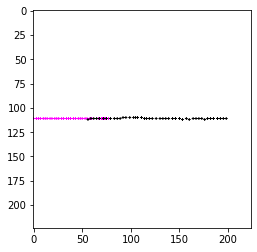

0


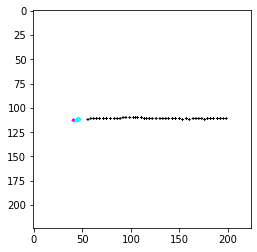

1


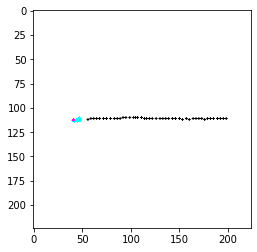

2


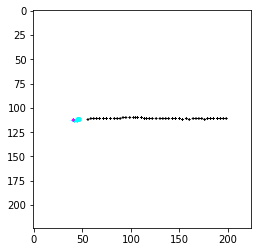

3


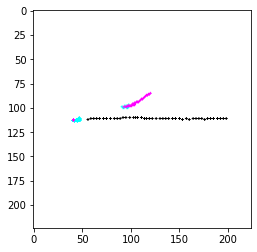

4


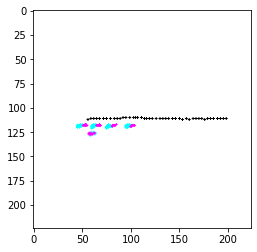

5


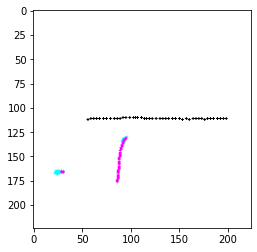

6


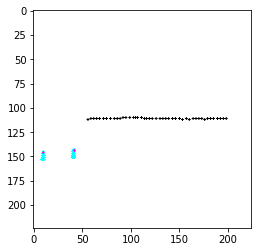

7


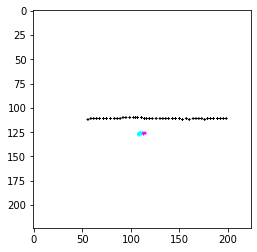

8


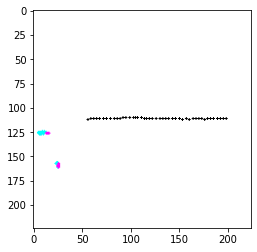

9


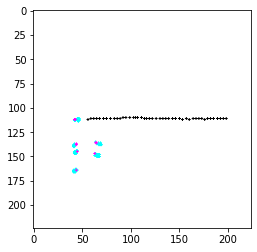

10


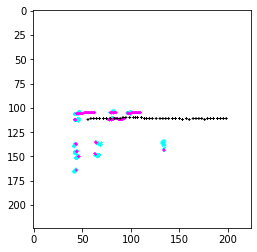

11


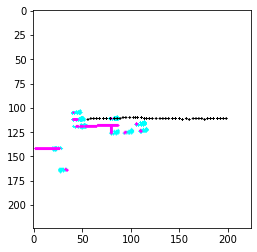

12


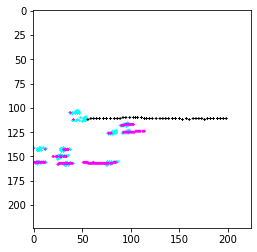

13


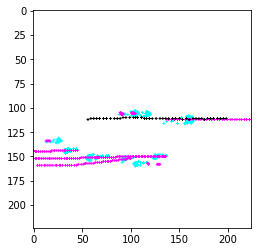

14


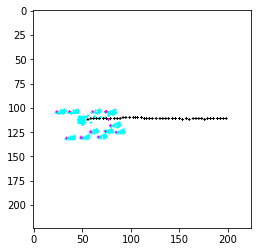

15


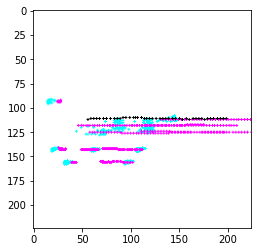

16


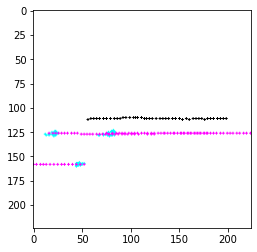

17


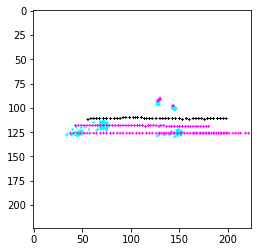

18


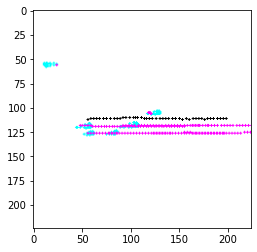

19


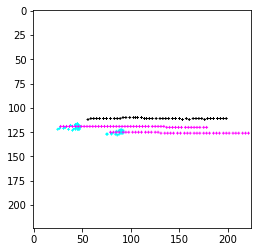

20


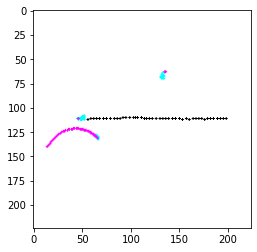

21


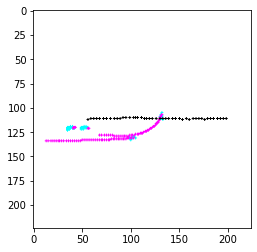

22


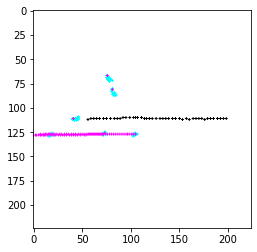

23


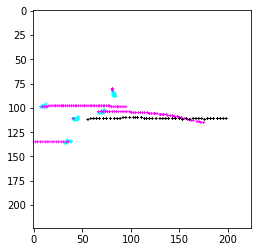

24


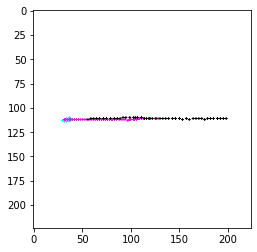

25


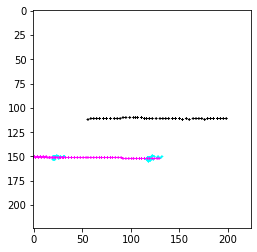

26


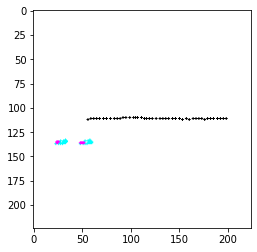

27


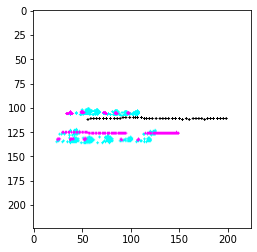

28


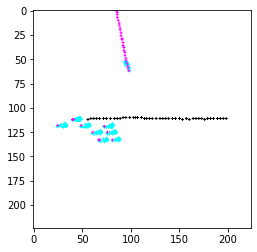

29


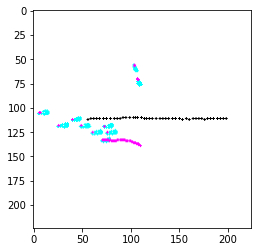

30


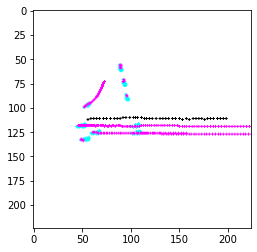

31


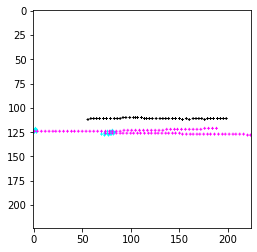

32


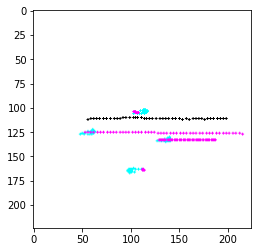

33


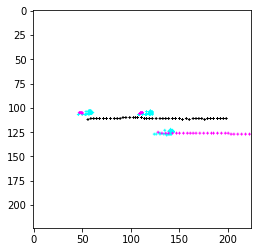

34


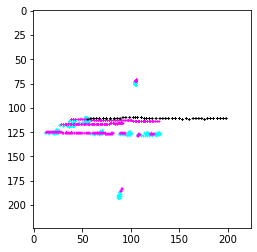

35


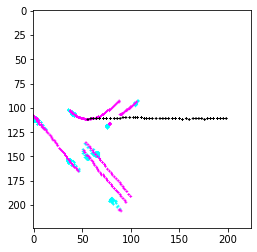

36


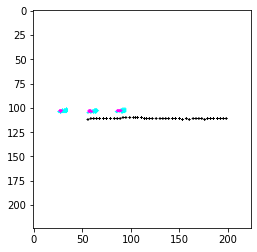

37


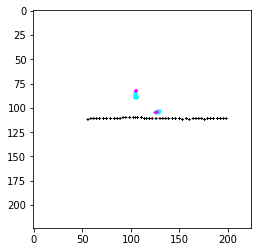

38


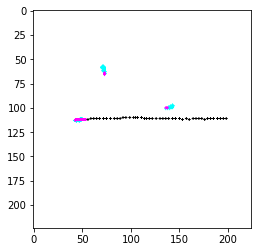

39


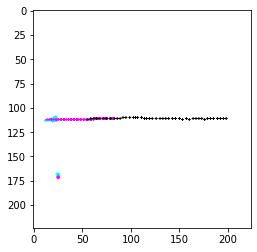

40


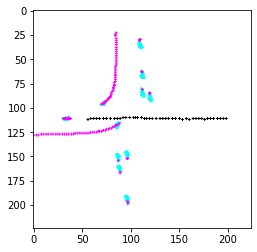

41


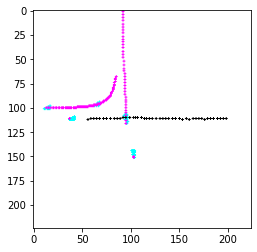

42


In [ ]:
def get_least(frame):
    model.eval()
    torch.set_grad_enabled(False)
    count = 0
    # build a dict to retrieve future trajectories from GT
    gt_rows = {}
    for row in read_gt_csv(eval_gt_path):
        gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

    eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

    for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
        agent_indices = eval_dataset.get_frame_indices(frame_number) 
        if not len(agent_indices):
            continue
        if count+1==frame:
            break
        # get AV point-of-view frame
        data_ego = eval_ego_dataset[frame_number]
        im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
        blank_image2 = 255 * np.ones(shape=[224, 224, 3], dtype=np.uint8)
        # plt.imshow(blank_image2)
        # plt.show()
        center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]

        predicted_positions = []
        target_positions = []

        for v_index in agent_indices:
            data_agent = eval_dataset[v_index]

            out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
            out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
            # store absolute world coordinates
            predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
            # retrieve target positions from the GT and store as absolute coordinates
            track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
            target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


        # convert coordinates to AV point-of-view so we can draw them
        predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
        target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

        draw_trajectory(blank_image2, predicted_positions, PREDICTED_POINTS_COLOR)
        # print(predicted_positions)
        draw_trajectory(blank_image2, target_positions, TARGET_POINTS_COLOR)
        draw_trajectory(blank_image2, ego_target, (0,0,0))
        plt.imshow(blank_image2)
        plt.show()
        print(count)
        count+=1
    pos = None
    least = np.asarray([10,10])
    for i in range(len(ego_target)):
        for j in range(len(target_positions)):
            current = abs(ego_target[i] - target_positions[j])
            result = current < least
            # print(current)
            # print(result)
            if result[0] and result[1]:
                pos = target_positions[j]
                least = result
    return pos

predIntersection = get_least(44)

In [ ]:
frame = 44

## Visualizing the intersection point
We are Visualizing the ego vehicle(orange dot) and the intersection point(Dark blue dot)

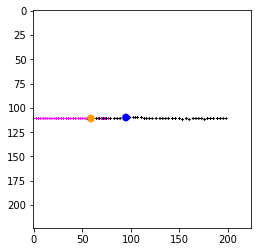

0


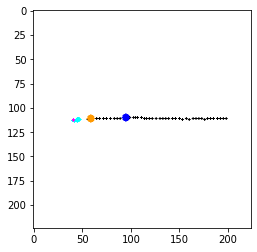

1


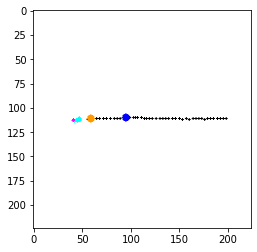

2


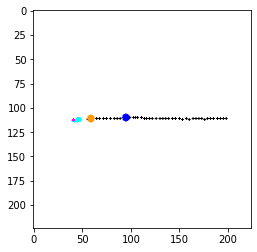

3


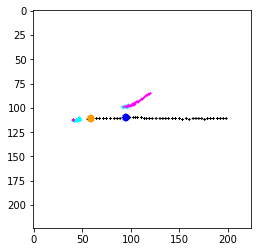

4


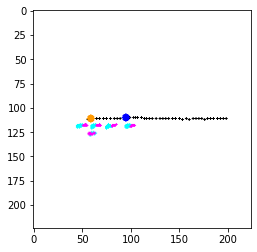

5


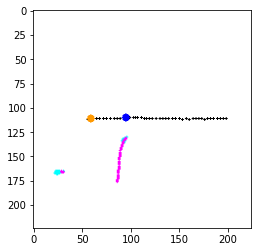

6


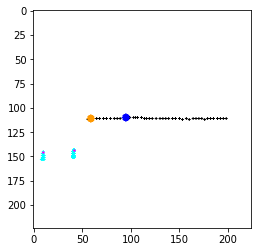

7


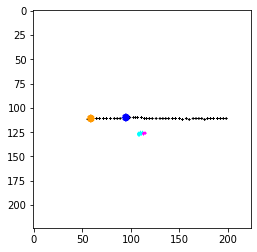

8


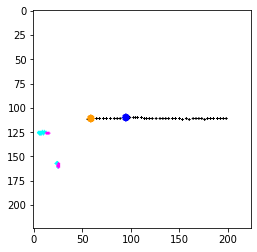

9


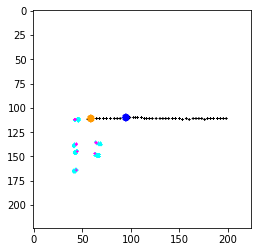

10


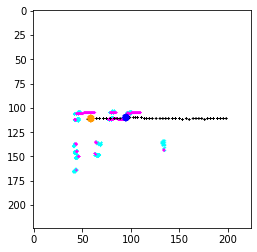

11


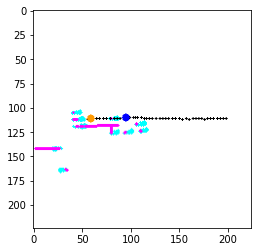

12


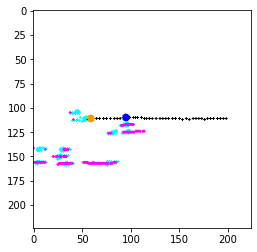

13


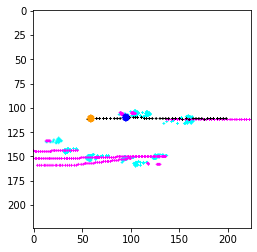

14


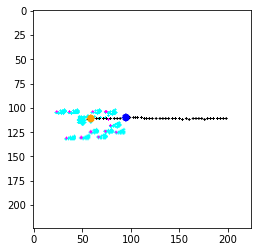

15


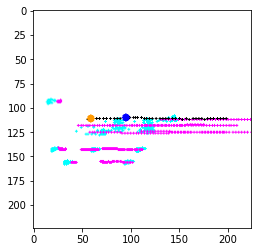

16


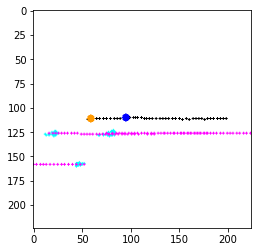

17


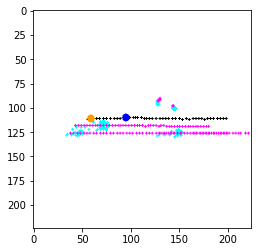

18


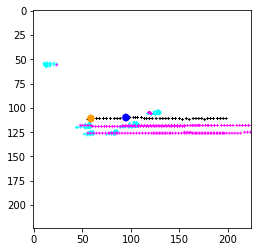

19


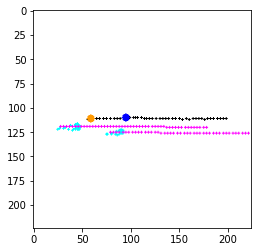

20


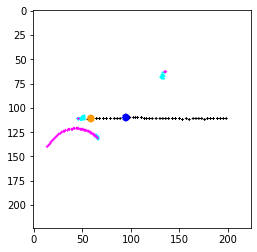

21


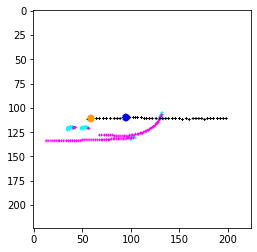

22


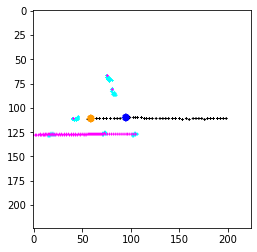

23


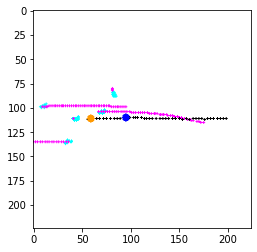

24


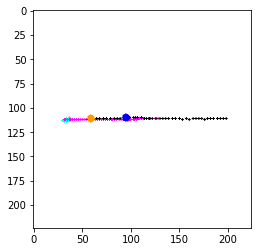

25


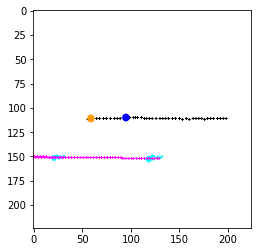

26


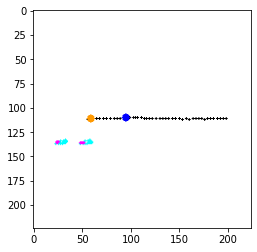

27


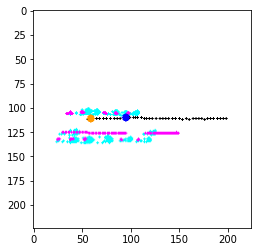

28


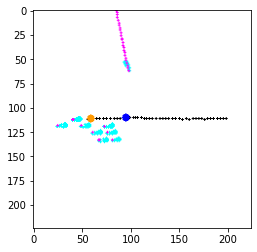

29


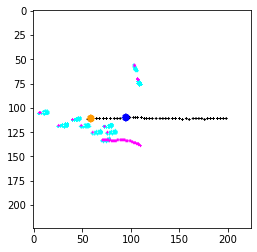

30


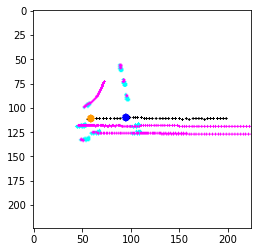

31


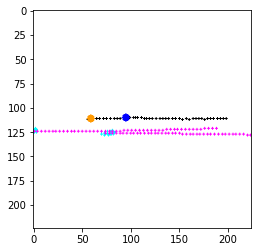

32


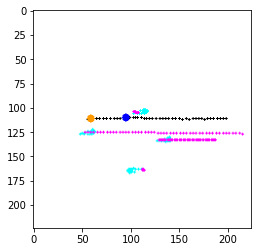

33


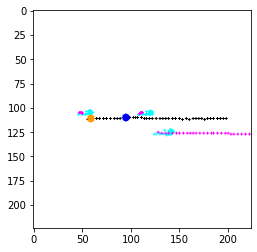

34


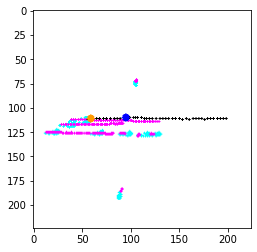

35


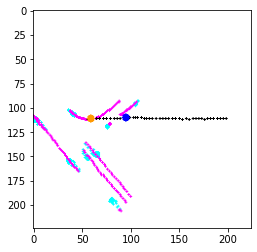

36


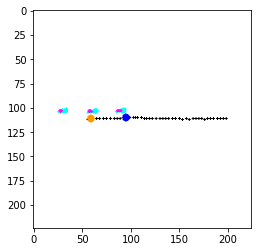

37


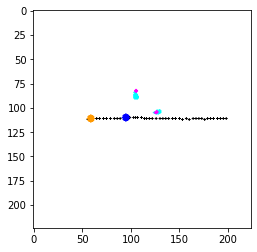

38


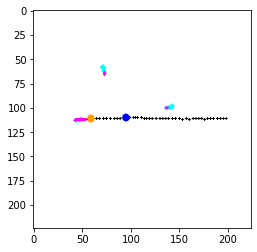

39


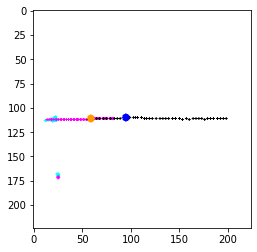

40


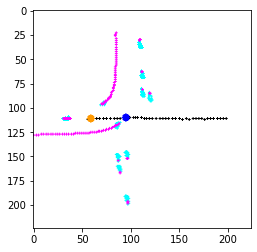

41


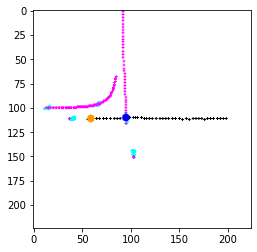

42


In [ ]:
model.eval()
torch.set_grad_enabled(False)
count = 0
# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue
    if count+1==frame:
        break
    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    blank_image2 = 255 * np.ones(shape=[224, 224, 3], dtype=np.uint8)
    # plt.imshow(blank_image2)
    # plt.show()
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]

    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(blank_image2, predicted_positions, PREDICTED_POINTS_COLOR)
    # print(predicted_positions)
    draw_trajectory(blank_image2, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(blank_image2, ego_target, (0,0,0))
    cv2.circle(blank_image2, (int(ego_target[0][0]),int(ego_target[0][1])), radius=1, color=(255, 153, 0), thickness=5)
    cv2.circle(blank_image2, (int(predIntersection[0]),int(predIntersection[1])), radius=1, color=(0, 0, 255), thickness=5)
    plt.imshow(blank_image2)
    plt.show()
    print(count)
    count+=1

## Distance Calculation 
We are calculating the predicted distance between ego_vehicle and the intersection point using the euclidean distance formula.

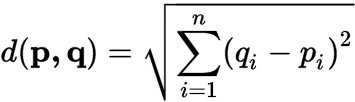

In [ ]:
dist = np.linalg.norm(predIntersection-ego_target[0])
dist

36.239768208163206

### Braking Alert
We are transfering control from prediction model to the actuation layer.
We intend to mimic the braking system with the following code.

In [ ]:
def brakingValue(distance):
    if distance <=11:
        print("High Braking")
    elif distance > 11  and distance <=22:
        print("Mid Braking")
    else:
        print("ADAS off")

In [ ]:
brakingValue(dist)

ADAS off
